1. ### Generate the network of interest for Task 1

In [130]:
#Define Network name. (Set a unique name for the generated network graph downloaded from OSM)
network_name = 'porto_whole1' 


#Essential function to save graph in special format for FMM
def save_graph_shapefile_directional(G, filepath=None, encoding="utf-8"):
    # default filepath if none was provided
    if filepath is None:
        filepath = os.path.join(ox.settings.data_folder, "graph_shapefile")

    # if save folder does not already exist, create it (shapefiles
    # get saved as set of files)
    if not filepath == "" and not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath_nodes = os.path.join(filepath, "nodes.shp")
    filepath_edges = os.path.join(filepath, "edges.shp")

    # convert undirected graph to gdfs and stringify non-numeric columns
    gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
    gdf_nodes = ox.io._stringify_nonnumeric_cols(gdf_nodes)
    gdf_edges = ox.io._stringify_nonnumeric_cols(gdf_edges)
    # We need an unique ID for each edge
    gdf_edges["fid"] = np.arange(0, gdf_edges.shape[0], dtype='int')

    # save the nodes and edges as separate ESRI shapefiles
    gdf_nodes.to_file(filepath_nodes, encoding=encoding)
    gdf_edges.to_file(filepath_edges, encoding=encoding)

print("osmnx version",ox.__version__)


osmnx version 1.2.2


C:\Users\guang\AppData\Local\Temp\ipykernel_736\3650383286.py:26: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, encoding=encoding)


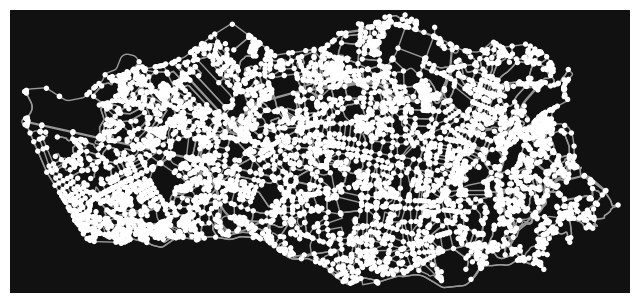

--- 22.00015687942505 seconds ---


In [118]:
#Method 1. (download the entire porto network based on the polylines provided by OSM)
#Save graph to use as input for cyang's FMM (Extract Whole Porto)

#change the place as required. 
place ="Porto, Portugal"

import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np
%matplotlib inline


start_time = time.time()
G2 = ox.graph_from_place(place, network_type='drive')
save_graph_shapefile_directional(G2, filepath='./' + network_name)
fig, ax = ox.plot_graph(G2)
ox.save_graphml(G, filepath = './' + network_name + '/saved_osmnx_graph')
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
#Method 2. (download a much bigger map beyond porto to ensure all trajectory well covered)
#Save graph to use as input for cyang's FMM (Extra all relevant space that the train-1000.csv to perform fmm mapmatching)
import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np

%matplotlib inline
#bounds will be set to generate each graph of interest
#bounds = (18.01141, 18.02459, 59.32615, 59.32889)

#generate min/max x and min/max y using 4. below to analyze one individual trajectory
#bounds = (min_x - 0.002, max_x + 0.002, min_y - 0.002, max_y + 0.002)

#As per train-1000.csv. The min/max Lat is 41.008275/41.260086. The min/max Long is -8.709399/-8.486757
#bounds are described by min,max long followed by min,max lat 
start_time = time.time()
bounds = (-8.709399, -8.486757, 41.008275, 41.260086)
x1,x2,y1,y2 = bounds
boundary_polygon = Polygon([(x1,y1),(x2,y1),(x2,y2),(x1,y2)])
G = ox.graph_from_polygon(boundary_polygon, network_type='drive')
fig, ax = ox.plot_graph(G)
save_graph_shapefile_directional(G, filepath='./' + network_name)
ox.save_graphml(G, filepath = './' + network_name + '/saved_osmnx_graph')
print("--- %s seconds ---" % (time.time() - start_time))

In [111]:
import geopandas as gp
print("Show some sample edges from the graph")
edge_dataframe = gp.GeoDataFrame.from_file(network_name + "/edges.shp")

print("Total edges in the graph: ", len(edge_dataframe))
edge_dataframe.head()

Show some sample edges from the graph
Total edges in the graph:  11095


,u,v,key,osmid,oneway,highway,reversed,length,lanes,ref,maxspeed,bridge,name,width,access,junction,tunnel,area,fid,geometry
0,25503936,4722746638,0,479127843,1,motorway_link,False,32.388,None,None,None,None,None,None,None,None,None,None,0,"LINESTRING (-8.64064 41.16607, -8.64091 41.16628)"
1,25503936,281726624,0,4256507,1,motorway_link,False,224.655,None,None,None,None,None,None,None,None,None,None,1,"LINESTRING (-8.64064 41.16607, -8.64072 41.166..."
2,25503951,1243857957,0,4256513,1,motorway_link,False,115.105,1,IC 1,60,None,None,None,None,None,None,None,2,"LINESTRING (-8.64204 41.16835, -8.64234 41.168..."
3,25503951,4507024043,0,158906049,1,motorway_link,False,191.892,1,None,None,None,None,None,None,None,None,None,3,"LINESTRING (-8.64204 41.16835, -8.64222 41.168..."
4,25504027,1243857999,0,"[4256491, 108390772, 479127839]",1,motorway_link,False,118.915,"['1', '2']",None,40,yes,None,None,None,None,None,None,4,"LINESTRING (-8.64159 41.16689, -8.64173 41.167..."


In [112]:
import geopandas as gp
print("Show some sample nodes from the graph")
nodes_dataframe = gp.GeoDataFrame.from_file(network_name + "/nodes.shp")

print("Total nodes in the graph: ", len(nodes_dataframe))
edge_dataframe.head()


Show some sample nodes from the graph
Total nodes in the graph:  5210


,u,v,key,osmid,oneway,highway,reversed,length,lanes,ref,maxspeed,bridge,name,width,access,junction,tunnel,area,fid,geometry
0,25503936,4722746638,0,479127843,1,motorway_link,False,32.388,None,None,None,None,None,None,None,None,None,None,0,"LINESTRING (-8.64064 41.16607, -8.64091 41.16628)"
1,25503936,281726624,0,4256507,1,motorway_link,False,224.655,None,None,None,None,None,None,None,None,None,None,1,"LINESTRING (-8.64064 41.16607, -8.64072 41.166..."
2,25503951,1243857957,0,4256513,1,motorway_link,False,115.105,1,IC 1,60,None,None,None,None,None,None,None,2,"LINESTRING (-8.64204 41.16835, -8.64234 41.168..."
3,25503951,4507024043,0,158906049,1,motorway_link,False,191.892,1,None,None,None,None,None,None,None,None,None,3,"LINESTRING (-8.64204 41.16835, -8.64222 41.168..."
4,25504027,1243857999,0,"[4256491, 108390772, 479127839]",1,motorway_link,False,118.915,"['1', '2']",None,40,yes,None,None,None,None,None,None,4,"LINESTRING (-8.64159 41.16689, -8.64173 41.167..."


### POST  PROCESS FMM Output (Relevant for Task 3)

In [ ]:
#Convert cpath output to a list of nodes osmID list and edges osmID list 

#Convert linestring output to a list of WSG84 Points

#Mark each data instance as a failed of successful FMM mapped trajectory

#Save the post-processed output under 5 columns csv file, 
#col1: trajectory ID, col2: original raw GPS point list, col3: fmm-mapped node indice sequence, 
#col4: fmm-mapped edge indice sequence, col5: fmm-mapped WSG84 points sequence 

###  Load the saved network (Relevant for Task 4)

In [122]:
network_name = "porto_whole1"

#Save graph to use as input for cyang's FMM (Extract Whole Porto)
import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np
%matplotlib inline


G = ox.load_graphml(filepath = './' + network_name + '/saved_osmnx_graph')

In [123]:
G

### Visualization codes for Task 4 (Input: A set of WSG84 points or cpath output Edges from FMM) (Output: Visualization of the points on Graph G)

complete preprocess: traversed node osmid list
[112613631, 128651490, 792643017, 1731170872, 1731170854, 1731170804, 3570149417, 122491912, 1731170260, 447867547, 122491913, 789709529, 299580145, 299599582, 299590514, 299583544, 299590114, 299590394, 1108076408, 299584051, 299585301, 1334167600]
complete preprocess: traversed edge osmid list
[[743461566], [1016528097], [13799462], [13799462], [13799462], [13799456], [351255845], [549454251, 351255844], [161123863], [161123865, 549454253], [253026357], [536714330], [27290127], [27290127], [27290127], [27290127], [27290902], [27290137], [27290454], [27290486], [34640002]]


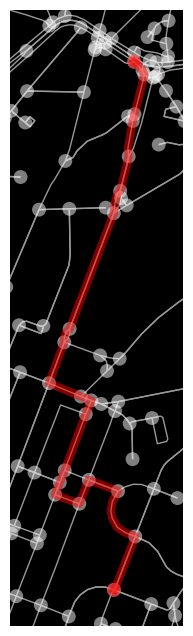

In [127]:
#Alternative visualization method, based on edge cpath data provided by FMM 
#(Less Prefered)
output_cpath = [336,648,4840,6928,6920,6919,8594,446,6913,3083,451,4824,1177,1232,1209,1187,1206,1208,5058,1190,1194]
#op = "-8.6186233 41.141456,-8.6183463 41.14133,-8.6182629 41.141292,-8.6174342 41.140917,-8.6182629 41.141292,-8.6183463 41.14133,-8.6187144 41.141497,-8.6188491 41.141582,-8.6198235 41.142218,-8.6200853 41.142389,-8.6202318 41.14249,-8.6203556 41.142575,-8.6209478 41.143157,-8.6212837 41.143398,-8.6213339 41.143434,-8.6216294 41.143598,-8.6216904 41.143624,-8.6220438 41.143771,-8.6225335 41.143949,-8.6231598 41.144138,-8.6235745 41.144265,-8.6243174 41.144494,-8.6247666 41.144632,-8.6250934 41.144735,-8.6254106 41.144793,-8.6266799 41.14476,-8.6267551 41.144759,-8.6268987 41.144728,-8.627037 41.144713,-8.6271975 41.1447,-8.6273413 41.144688,-8.6274999 41.144678,-8.6276791 41.14467,-8.6278804 41.144665,-8.6280428 41.144668,-8.6282135 41.144678,-8.6284404 41.144699,-8.6286688 41.144731,-8.628864 41.144764,-8.6290926 41.144817,-8.6292898 41.144868,-8.6294324 41.144912,-8.6295694 41.144961,-8.629633 41.144985,-8.6297382 41.145024,-8.6299469 41.14512,-8.6301362 41.145216,-8.6303271 41.145324,-8.6307201 41.145592,-8.6307923 41.145641,-8.6314509 41.146137,-8.6315556 41.146204,-8.6316434 41.14626,-8.6318066 41.146363,-8.6326775 41.146843,-8.6328764 41.146954,-8.6327796 41.147062,-8.6327668 41.147077,-8.6327023 41.147151,-8.6326805 41.147177,-8.631553 41.148453,-8.6314991 41.148514,-8.6310069 41.149082,-8.6308723 41.149237,-8.6307611 41.149366,-8.6302954 41.149903,-8.6299508 41.150301,-8.6295157 41.150808,-8.6294233 41.150916,-8.6293113 41.151044,-8.6291323 41.151246,-8.6290736 41.151312,-8.6289862 41.151477,-8.6289736 41.15158,-8.6287691 41.152377,-8.628743 41.152478,-8.6289655 41.152491,-8.6296472 41.152529,-8.6301016 41.152554,-8.6304904 41.152576,-8.6306176 41.152584,-8.6308068 41.152592,-8.6309917 41.152601,-8.6313575 41.152617,-8.6314821 41.15268,-8.6321685 41.15273,-8.6322295 41.152796,-8.6322941 41.152875,-8.6322538 41.15327,-8.6321804 41.153466,-8.6322 41.153604,-8.6321425 41.153694,-8.6320578 41.153797,-8.6319742 41.153879,-8.6318622 41.153974,-8.6318156 41.154007,-8.6317376 41.154068,-8.6313664 41.15433,-8.6310274 41.154568,-8.6308755 41.154531,-8.6307169 41.154492,-8.6307169 41.154492"
op = "-8.5823907 41.1805609,-8.5823595 41.1805399,-8.5823313 41.1805165,-8.5821775 41.1803973,-8.5821614 41.180354,-8.5821307 41.1803155,-8.5821696 41.180179,-8.582383 41.1795489,-8.5824257 41.1794192,-8.5825385 41.1789475,-8.5825509 41.1788928,-8.582531 41.1787347,-8.5825724 41.1785832,-8.5827491 41.1780689,-8.5828188 41.1780228,-8.5828872 41.1778242,-8.5829006 41.1777116,-8.5829121 41.1776376,-8.5830282 41.1774087,-8.5840446 41.1754051,-8.5841263 41.1753548,-8.5841772 41.1752539,-8.5841826 41.1751469,-8.5842302 41.1750508,-8.5842576 41.1749955,-8.5843382 41.1748326,-8.5845113 41.1744827,-8.5845737 41.1743566,-8.5844098 41.174305,-8.5841489 41.1742229,-8.5837551 41.1740989,-8.5836288 41.174063,-8.5834872 41.1740228,-8.5835239 41.1739554,-8.5836311 41.1737583,-8.5841719 41.1726719,-8.5842969 41.1724402,-8.5844178 41.1722025,-8.5837966 41.1720283,-8.5835548 41.1724894,-8.582952 41.1723154,-8.582804 41.1722722,-8.5829526 41.1720634,-8.5829883 41.1718865,-8.582953 41.1717493,-8.5828221 41.1715734,-8.5826242 41.1714726,-8.5823612 41.1713979,-8.58273627149 41.1706680561" 
sample_output_list = op.split(",")
latList = []
longList = []

#calculate the min max points so we know where to focus and zoom into relevant space, 
#essential to ensure optimal visual 
minX, maxX, minY, maxY = 180, -180, 90, -90
for pt in sample_output_list:
    pt_list = pt.split(" ")
    long = float(pt_list[0])
    lat = float(pt_list[1])
    latList.append(lat)
    longList.append(long)
    if minY > lat:
        minY = lat
    if maxY < lat:
        maxY = lat
    if minX > long:
        minX = long
    if maxX < long:
        maxX = long

#Look at the nodes
import geopandas as gp

#set to relevant Graph G network files that were saved using FMM author's method
nodes_shp = gp.GeoDataFrame.from_file(network_name + "/nodes.shp")
edges_shp = gp.GeoDataFrame.from_file(network_name + "/edges.shp")
#point_of_int = str(node_shp['geometry'][1])
#pt_e = point_of_int[7:len(point_of_int)-1]
nodeList = []
edgeList = []
for edge in output_cpath:
    edge_osmID_str = edges_shp['osmid'][edge]
    if '[' in edge_osmID_str:
        edgeID = [int(n) for n in edge_osmID_str.strip('][').split(', ')]
    else:
        edgeID = [int(edge_osmID_str)] 
    edgeList.append(edgeID)
    prevNode = int(edges_shp['u'][edge])
    nextNode = int(edges_shp['v'][edge])
    if len(nodeList) == 0 or nodeList[len(nodeList)-1] != prevNode:
        nodeList.append(prevNode)
    nodeList.append(nextNode)
print("complete preprocess: traversed node osmid list")
print(nodeList)
print("complete preprocess: traversed edge osmid list")
print(edgeList)

#Visualize all the edges traversed 

fig, ax = ox.plot_graph_route(G, nodeList, route_linewidth=6, node_size=100, bgcolor='k', 
                              show=False, close=False,node_alpha=0.5,edge_alpha=1.0)
plt.xlim([minX-0.001,  maxX+0.001])
plt.ylim([minY-0.001, maxY+0.001])
plt.show()

Final Lats and Long List processed:
[41.1805609, 41.1805399, 41.1805165, 41.1803973, 41.180354, 41.1803155, 41.180179, 41.1795489, 41.1794192, 41.1789475, 41.1788928, 41.1787347, 41.1785832, 41.1780689, 41.1780228, 41.1778242, 41.1777116, 41.1776376, 41.1774087, 41.1754051, 41.1753548, 41.1752539, 41.1751469, 41.1750508, 41.1749955, 41.1748326, 41.1744827, 41.1743566, 41.174305, 41.1742229, 41.1740989, 41.174063, 41.1740228, 41.1739554, 41.1737583, 41.1726719, 41.1724402, 41.1722025, 41.1720283, 41.1724894, 41.1723154, 41.1722722, 41.1720634, 41.1718865, 41.1717493, 41.1715734, 41.1714726, 41.1713979, 41.1706680561]
[-8.5823907, -8.5823595, -8.5823313, -8.5821775, -8.5821614, -8.5821307, -8.5821696, -8.582383, -8.5824257, -8.5825385, -8.5825509, -8.582531, -8.5825724, -8.5827491, -8.5828188, -8.5828872, -8.5829006, -8.5829121, -8.5830282, -8.5840446, -8.5841263, -8.5841772, -8.5841826, -8.5842302, -8.5842576, -8.5843382, -8.5845113, -8.5845737, -8.5844098, -8.5841489, -8.5837551, -8.58

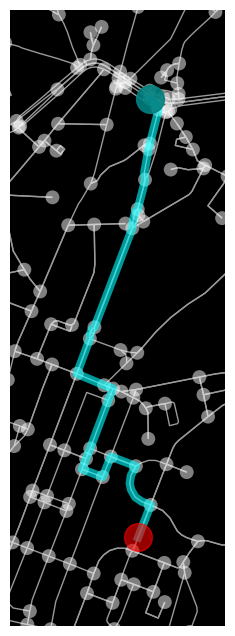

In [129]:
#Visualize Map Matching output using the linestring produced (Recommended)

#Set this to visualize the WSG84 points
#op = "-8.6186233 41.141456,-8.6183463 41.14133,-8.6182629 41.141292,-8.6174342 41.140917,-8.6182629 41.141292,-8.6183463 41.14133,-8.6187144 41.141497,-8.6188491 41.141582,-8.6198235 41.142218,-8.6200853 41.142389,-8.6202318 41.14249,-8.6203556 41.142575,-8.6209478 41.143157,-8.6212837 41.143398,-8.6213339 41.143434,-8.6216294 41.143598,-8.6216904 41.143624,-8.6220438 41.143771,-8.6225335 41.143949,-8.6231598 41.144138,-8.6235745 41.144265,-8.6243174 41.144494,-8.6247666 41.144632,-8.6250934 41.144735,-8.6254106 41.144793,-8.6266799 41.14476,-8.6267551 41.144759,-8.6268987 41.144728,-8.627037 41.144713,-8.6271975 41.1447,-8.6273413 41.144688,-8.6274999 41.144678,-8.6276791 41.14467,-8.6278804 41.144665,-8.6280428 41.144668,-8.6282135 41.144678,-8.6284404 41.144699,-8.6286688 41.144731,-8.628864 41.144764,-8.6290926 41.144817,-8.6292898 41.144868,-8.6294324 41.144912,-8.6295694 41.144961,-8.629633 41.144985,-8.6297382 41.145024,-8.6299469 41.14512,-8.6301362 41.145216,-8.6303271 41.145324,-8.6307201 41.145592,-8.6307923 41.145641,-8.6314509 41.146137,-8.6315556 41.146204,-8.6316434 41.14626,-8.6318066 41.146363,-8.6326775 41.146843,-8.6328764 41.146954,-8.6327796 41.147062,-8.6327668 41.147077,-8.6327023 41.147151,-8.6326805 41.147177,-8.631553 41.148453,-8.6314991 41.148514,-8.6310069 41.149082,-8.6308723 41.149237,-8.6307611 41.149366,-8.6302954 41.149903,-8.6299508 41.150301,-8.6295157 41.150808,-8.6294233 41.150916,-8.6293113 41.151044,-8.6291323 41.151246,-8.6290736 41.151312,-8.6289862 41.151477,-8.6289736 41.15158,-8.6287691 41.152377,-8.628743 41.152478,-8.6289655 41.152491,-8.6296472 41.152529,-8.6301016 41.152554,-8.6304904 41.152576,-8.6306176 41.152584,-8.6308068 41.152592,-8.6309917 41.152601,-8.6313575 41.152617,-8.6314821 41.15268,-8.6321685 41.15273,-8.6322295 41.152796,-8.6322941 41.152875,-8.6322538 41.15327,-8.6321804 41.153466,-8.6322 41.153604,-8.6321425 41.153694,-8.6320578 41.153797,-8.6319742 41.153879,-8.6318622 41.153974,-8.6318156 41.154007,-8.6317376 41.154068,-8.6313664 41.15433,-8.6310274 41.154568,-8.6308755 41.154531,-8.6307169 41.154492,-8.6307169 41.154492"
op = "-8.5823907 41.1805609,-8.5823595 41.1805399,-8.5823313 41.1805165,-8.5821775 41.1803973,-8.5821614 41.180354,-8.5821307 41.1803155,-8.5821696 41.180179,-8.582383 41.1795489,-8.5824257 41.1794192,-8.5825385 41.1789475,-8.5825509 41.1788928,-8.582531 41.1787347,-8.5825724 41.1785832,-8.5827491 41.1780689,-8.5828188 41.1780228,-8.5828872 41.1778242,-8.5829006 41.1777116,-8.5829121 41.1776376,-8.5830282 41.1774087,-8.5840446 41.1754051,-8.5841263 41.1753548,-8.5841772 41.1752539,-8.5841826 41.1751469,-8.5842302 41.1750508,-8.5842576 41.1749955,-8.5843382 41.1748326,-8.5845113 41.1744827,-8.5845737 41.1743566,-8.5844098 41.174305,-8.5841489 41.1742229,-8.5837551 41.1740989,-8.5836288 41.174063,-8.5834872 41.1740228,-8.5835239 41.1739554,-8.5836311 41.1737583,-8.5841719 41.1726719,-8.5842969 41.1724402,-8.5844178 41.1722025,-8.5837966 41.1720283,-8.5835548 41.1724894,-8.582952 41.1723154,-8.582804 41.1722722,-8.5829526 41.1720634,-8.5829883 41.1718865,-8.582953 41.1717493,-8.5828221 41.1715734,-8.5826242 41.1714726,-8.5823612 41.1713979,-8.58273627149 41.1706680561" 
sample_output_list = op.split(",")
latList = []
longList = []

#calculate the min max points so we know where to focus and zoom into relevant space, 
#essential to ensure optimal visual 
minX, maxX, minY, maxY = 180, -180, 90, -90
for pt in sample_output_list:
    pt_list = pt.split(" ")
    lat = float(pt_list[1])
    long = float(pt_list[0])
    latList.append(lat)
    longList.append(long)
    if minX > long:
        minX = long
    if maxX < long:
        maxX = long
    if minY > lat:
        minY = lat
    if maxY < lat:
        maxY = lat
    
print("Final Lats and Long List processed:")
print(latList)
print(longList)
    

import matplotlib.pyplot as plt 

fig, ax = ox.plot_graph(G, show=False, close=False,node_alpha=0.5,edge_alpha=1.0, 
                        bgcolor='black',node_color='white', node_size=100)
plt.plot(longList,latList,"cyan", alpha=0.6, linewidth=6)
#mark start point
plt.plot(longList[0], latList[0], c="teal", alpha=0.9, markersize=20, marker ="o")
#mark end point
plt.plot(longList[len(longList)-1], latList[len(latList)-1], c="red", alpha=0.6, markersize=20, marker ="o")
plt.xlim([minX - 0.002,  maxX + 0.002])
plt.ylim([minY - 0.002, maxY + 0.002])
plt.show()

### Analysis of Map matching result Python code (Task 5)

In [ ]:
#Process the post-processed fmm output to build a table describing how many times each edges were traverse

#print and visualize the top 5 road segment (edges) that were traversed by the 1000 trajectories (Task 5(1))

#An algorithm to associate each of the trajectory GPS points to a relevant edge, 

#for each trajectory data:

#for each GPS point in trajectory data:
#compares if the GPS point is nearest to the active edge 'destination v' field or the incoming edge 'origin u' field. 
#if GPS point is near to the active edge destination, assign +1 point to the active edge and move to analyze the next GPS point, 
#else if GPS point is near to the incoming edge origin, assign +1 point to the incoming edge, 
#then update active edge as incoming edge. Move on to the next GPS point. 
#:until all the GPS point in trajectory are assigned to an edge traversed.

#for each edge traversed in this trajectory data:
#update the sum total time taken to traversed all the relevant edge for all trajectory point 
#(needed to find average time traveled for each edge later)

#:until all trajectory data completed the above

#for each edge traversed in the 1000 trajectories.
#average_duration = divide the sum total time traversed by all 1000 trajectories by the number of times each edges were traversed
#this average duration is in GPS points per traverse attempt
#For each GPS point assiocated to the edge, 15seconds were spent. 
#Total approximate time can be calculated as 15s * no of GPS point allocated to this edge 

#Print and visualize the top 5 edges that were assigned the most GPS point per traverse attempt. (Task 5 (2))

#For each GPS point assigned means that the edge took 15s


### Convert Individual polyline trajectory x from kaggle dataset to wkt LINESTRING for direct input into FMM (Supplemental code to understand and test FMM algorithm)

In [113]:
x = [[-8.618643,41.141412],[-8.618499,41.141376],[-8.620326,41.14251],[-8.622153,41.143815],[-8.623953,41.144373],[-8.62668,41.144778],[-8.627373,41.144697],[-8.630226,41.14521],[-8.632746,41.14692],[-8.631738,41.148225],[-8.629938,41.150385],[-8.62911,41.151213],[-8.629128,41.15124],[-8.628786,41.152203],[-8.628687,41.152374],[-8.628759,41.152518],[-8.630838,41.15268],[-8.632323,41.153022],[-8.631144,41.154489],[-8.630829,41.154507],[-8.630829,41.154516],[-8.630829,41.154498],[-8.630838,41.154489]]
min_x, max_x, min_y, max_y = 180, -180, 90, -90
wkt_str = "LINESTRING("
for pt in x:
    if pt[0] > max_x:
        max_x = pt[0]
    if pt[0] < min_x:
        min_x = pt[0]
    if pt[1] > max_y:
        max_y = pt[1]
    if pt[1] < min_y:
        min_y = pt[1]
    wkt_str += str(pt[0]) + " " + str(pt[1]) + ","
wkt_str = wkt_str[0:len(wkt_str)-1] + ")"

In [115]:
print("Sample input data for FMM:", wkt_str)

#the min max points is essential to plot visualization 
#such that the plot optimally focus on the area of coverage to clear visual
print("MinX", min_x)
print("MaxX", max_x)
print("MinY", min_y)
print("MaxY", max_y)

Sample input data for FMM: LINESTRING(-8.618643 41.141412,-8.618499 41.141376,-8.620326 41.14251,-8.622153 41.143815,-8.623953 41.144373,-8.62668 41.144778,-8.627373 41.144697,-8.630226 41.14521,-8.632746 41.14692,-8.631738 41.148225,-8.629938 41.150385,-8.62911 41.151213,-8.629128 41.15124,-8.628786 41.152203,-8.628687 41.152374,-8.628759 41.152518,-8.630838 41.15268,-8.632323 41.153022,-8.631144 41.154489,-8.630829 41.154507,-8.630829 41.154516,-8.630829 41.154498,-8.630838 41.154489)
MinX -8.632746
MaxX -8.618499
MinY 41.141376
MaxY 41.154516
